# IF3270 Machine Learning | Tugas Besar 2


Group Number: 46

Group Members:
- Ariel Herfrison (13522002)
- Zachary Samuel Tobing (13522016)
- Imam Hanif Mulyarahman (13522030)

## Import Libraries

In [82]:
import random
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, TextVectorization
from tensorflow.keras.metrics import F1Score
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
import os


In [ ]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

seed = 42
os.environ['PYTHONHASHSEED']=str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

## Import Dataset

In [6]:
url_train = "https://raw.githubusercontent.com/IndoNLP/nusax/refs/heads/main/datasets/sentiment/indonesian/train.csv"
train = pd.read_csv(url_train)

url_val = "https://raw.githubusercontent.com/IndoNLP/nusax/refs/heads/main/datasets/sentiment/indonesian/valid.csv"
val = pd.read_csv(url_val)

url_test = "https://raw.githubusercontent.com/IndoNLP/nusax/refs/heads/main/datasets/sentiment/indonesian/test.csv"
test = pd.read_csv(url_test)

In [7]:
train.head()

,id,text,label
0,219,Nikmati cicilan 0% hingga 12 bulan untuk pemes...,neutral
1,209,Kue-kue yang disajikan bikin saya bernostalgia...,positive
2,436,Ibu pernah bekerja di grab indonesia,neutral
3,394,Paling suka banget makan siang di sini ayam sa...,positive
4,592,Pelayanan bus DAMRI sangat baik,positive


In [8]:
val.head()

,id,text,label
0,237,Jika ada pertanyaan lebih lanjut yang ingin ka...,neutral
1,101,Rasanya sih kok harga kaki lima dan rasanya ya...,negative
2,556,"Minimal cek pesan saya, ada problem yang rumit...",neutral
3,474,Dulu restoran ini merupakan favorit saya karen...,negative
4,42,Merupakan resto vintage dengan harga yang cuku...,positive


In [9]:
test.head()

,id,text,label
0,411,"Dekat dengan hotel saya menginap, hanya ditemp...",positive
1,729,"Iya benar, dia sedang jaga warung.",neutral
2,373,Kangkungnya lumayan tapi kepiting saus padangn...,negative
3,262,Bertempat di braga city walk yang satu gedung ...,positive
4,177,Gianyar terima bantuan sosial 2018 sebesar rp ...,neutral


In [10]:
train_df = train.copy()
val_df = val.copy()
test_df = test.copy()

In [11]:
max_len = train_df['text'].apply(lambda x: len(x.split())).max()
print(f"Maximum text length in train: {max_len}")

Maximum text length in train: 77


# Data Cleaning and Preprocessing

In [12]:
# Encoding (pos = 2, neut = 1, neg = 0)
labelEncoder = LabelEncoder()
train_df['label'] = labelEncoder.fit_transform(train_df['label'])
val_df['label'] = labelEncoder.fit_transform(val_df['label'])
test_df['label'] = labelEncoder.fit_transform(test_df['label'])


In [13]:
train_df.head()

,id,text,label
0,219,Nikmati cicilan 0% hingga 12 bulan untuk pemes...,1
1,209,Kue-kue yang disajikan bikin saya bernostalgia...,2
2,436,Ibu pernah bekerja di grab indonesia,1
3,394,Paling suka banget makan siang di sini ayam sa...,2
4,592,Pelayanan bus DAMRI sangat baik,2


In [14]:
val_df.head()

,id,text,label
0,237,Jika ada pertanyaan lebih lanjut yang ingin ka...,1
1,101,Rasanya sih kok harga kaki lima dan rasanya ya...,0
2,556,"Minimal cek pesan saya, ada problem yang rumit...",1
3,474,Dulu restoran ini merupakan favorit saya karen...,0
4,42,Merupakan resto vintage dengan harga yang cuku...,2


In [15]:

test_df.head()

,id,text,label
0,411,"Dekat dengan hotel saya menginap, hanya ditemp...",2
1,729,"Iya benar, dia sedang jaga warung.",1
2,373,Kangkungnya lumayan tapi kepiting saus padangn...,0
3,262,Bertempat di braga city walk yang satu gedung ...,2
4,177,Gianyar terima bantuan sosial 2018 sebesar rp ...,1


In [16]:
X_train = np.array(train_df['text'])
y_train = np.array(train_df['label'])

X_val = np.array(val_df['text'])
y_val = np.array(val_df['label'])

X_test = np.array(test_df['text'])
y_test = np.array(test_df['label'])

In [17]:
y_train_cat = to_categorical(y_train, num_classes=3)
y_val_cat = to_categorical(y_val, num_classes=3)
y_test_cat = to_categorical(y_test, num_classes=3)

# Modeling and Validation

In [ ]:
max_tokens = 10000 
max_len = 100

vectorize_layer = TextVectorization(
    max_tokens=max_tokens,
    output_mode='int',
    output_sequence_length=max_len)
vectorize_layer.adapt(X_train)

f1 = F1Score(average='macro')  # or 'micro'/'weighted'

# Base Model
base_model = Sequential([
    vectorize_layer,
    Embedding(input_dim=max_tokens, output_dim=128, mask_zero=True),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='softmax')
])

base_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=[f1]
)

# base_model.summary()

## 4.1 Variasi Jumlah Layer

### 4.1.1 Modeling

#### 4.1.1.1 Model 1

In [109]:
n_layer_1_model = Sequential([
    vectorize_layer,
    Embedding(input_dim=max_tokens, output_dim=64, mask_zero=True, embeddings_initializer=keras.initializers.RandomUniform(seed=42)),
    Bidirectional(LSTM(16, kernel_initializer=keras.initializers.GlorotNormal(seed=42))),
    Dropout(0.5, seed=42),
    Dense(3, activation='softmax', kernel_initializer=keras.initializers.GlorotNormal(seed=42))
])

n_layer_1_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=[f1]
)

#### 4.1.1.2 Model 2

In [110]:
n_layer_2_model = Sequential([
    vectorize_layer,
    Embedding(input_dim=max_tokens, output_dim=64, mask_zero=True, embeddings_initializer=keras.initializers.RandomUniform(seed=42)),
    Bidirectional(LSTM(16, return_sequences=True, kernel_initializer=keras.initializers.GlorotNormal(seed=42))),
    Bidirectional(LSTM(16, return_sequences=True, kernel_initializer=keras.initializers.GlorotNormal(seed=42))),
    Bidirectional(LSTM(16)),
    Dropout(0.5, seed=42),
    Dense(3, activation='softmax', kernel_initializer=keras.initializers.GlorotNormal(seed=42))
])

n_layer_2_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=[f1]
)

#### 4.1.1.3 Model 3

In [111]:
n_layer_3_model = Sequential([
    vectorize_layer,
    Embedding(input_dim=max_tokens, output_dim=64, mask_zero=True, embeddings_initializer=keras.initializers.RandomUniform(seed=42)),
    Bidirectional(LSTM(16, return_sequences=True, kernel_initializer=keras.initializers.GlorotNormal(seed=42))),
    Bidirectional(LSTM(16, return_sequences=True, kernel_initializer=keras.initializers.GlorotNormal(seed=42))),
    Bidirectional(LSTM(16, return_sequences=True, kernel_initializer=keras.initializers.GlorotNormal(seed=42))),
    Bidirectional(LSTM(16, return_sequences=True, kernel_initializer=keras.initializers.GlorotNormal(seed=42))),
    Bidirectional(LSTM(16, return_sequences=True, kernel_initializer=keras.initializers.GlorotNormal(seed=42))),
    Bidirectional(LSTM(16, return_sequences=True, kernel_initializer=keras.initializers.GlorotNormal(seed=42))),
    Bidirectional(LSTM(16)),
    Dropout(0.5, seed=42),
    Dense(3, activation='softmax', kernel_initializer=keras.initializers.GlorotNormal(seed=42))
])

n_layer_3_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=[f1]
)

### 4.1.2. Comparison and Analysis

Epoch 1/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 610ms/step - f1_score: 0.5548 - loss: 1.0942 - val_f1_score: 0.3739 - val_loss: 1.0764
Epoch 2/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 173ms/step - f1_score: 0.4407 - loss: 1.0527 - val_f1_score: 0.4085 - val_loss: 1.0495
Epoch 3/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 170ms/step - f1_score: 0.4518 - loss: 0.9985 - val_f1_score: 0.4624 - val_loss: 0.9994
Epoch 4/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 186ms/step - f1_score: 0.5107 - loss: 0.8743 - val_f1_score: 0.4960 - val_loss: 0.8944
Epoch 5/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 190ms/step - f1_score: 0.8177 - loss: 0.6501 - val_f1_score: 0.6831 - val_loss: 0.7366
Epoch 1/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 33s 530ms/step - f1_score: 0.4464 - loss: 1.0779 - val_f1_score: 0.1836 - val_loss: 1.0328
Epoch 2/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 329ms/step - f1_score: 0.2789 - loss: 0.9776 - val_f1_score: 0.3976 - val_loss: 0.9605
Epoch 3/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 349ms/step - f1_score: 0.5922 - loss: 0.8224 - val_f1_score: 0.6218 -

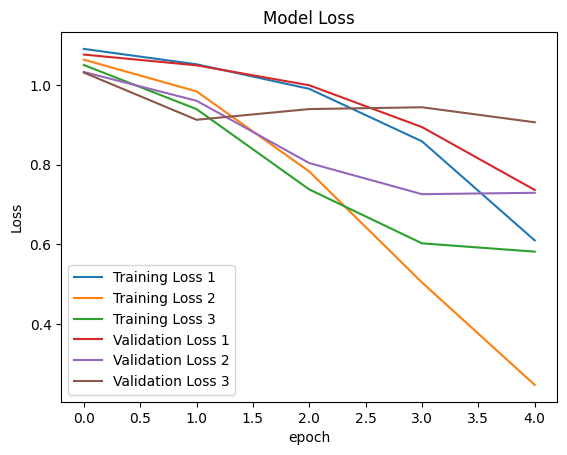

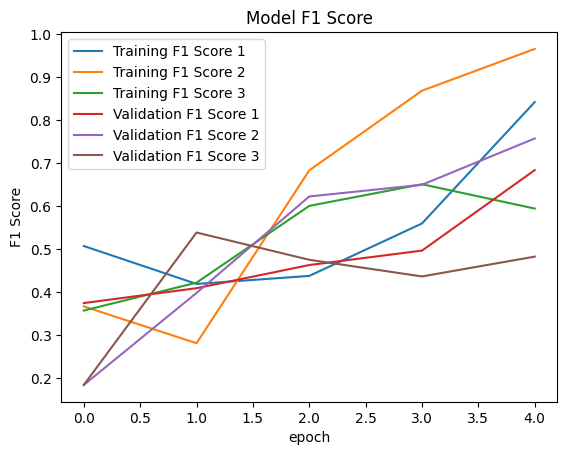

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - f1_score: 0.6573 - loss: 0.7947
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - f1_score: 0.6937 - loss: 0.8478
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step - f1_score: 0.4423 - loss: 1.0389
Test accuracy 1: 0.6711
Test accuracy 2: 0.6882
Test accuracy 3: 0.4688


In [112]:
history_1 = n_layer_1_model.fit(X_train, y_train_cat, validation_data = (X_val, y_val_cat), epochs=5, batch_size=32)
history_2 = n_layer_2_model.fit(X_train, y_train_cat, validation_data = (X_val, y_val_cat), epochs=5, batch_size=32)
history_3 = n_layer_3_model.fit(X_train, y_train_cat, validation_data = (X_val, y_val_cat), epochs=5, batch_size=32)

plt.plot(history_1.history['loss'], label="Training Loss 1")
plt.plot(history_2.history['loss'], label="Training Loss 2")
plt.plot(history_3.history['loss'], label="Training Loss 3")
plt.plot(history_1.history['val_loss'], label="Validation Loss 1")
plt.plot(history_2.history['val_loss'], label="Validation Loss 2")
plt.plot(history_3.history['val_loss'], label="Validation Loss 3")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

plt.plot(history_1.history['f1_score'], label="Training F1 Score 1")
plt.plot(history_2.history['f1_score'], label="Training F1 Score 2")
plt.plot(history_3.history['f1_score'], label="Training F1 Score 3")
plt.plot(history_1.history['val_f1_score'], label="Validation F1 Score 1")
plt.plot(history_2.history['val_f1_score'], label="Validation F1 Score 2")
plt.plot(history_3.history['val_f1_score'], label="Validation F1 Score 3")
plt.title('Model F1 Score')
plt.ylabel('F1 Score')
plt.xlabel('epoch')
plt.legend()
plt.show()

test_loss_1, test_acc_1 = n_layer_1_model.evaluate(X_test, y_test_cat)
test_loss_2, test_acc_2 = n_layer_2_model.evaluate(X_test, y_test_cat)
test_loss_3, test_acc_3 = n_layer_3_model.evaluate(X_test, y_test_cat)
print(f"Test accuracy 1: {test_acc_1:.4f}")
print(f"Test accuracy 2: {test_acc_2:.4f}")
print(f"Test accuracy 3: {test_acc_3:.4f}")



Peningkatan jumlah layer cenderung meningkatkan performa model, tetapi penggunaan layer yang terlalu banyak dapat menyebabkan overfitting.

## 4.2. Variasi Jumlah Cell

### 4.1.1. Modeling

#### 4.1.1.1 Model 1

In [119]:
n_cell_1_model = Sequential([
    vectorize_layer,
    Embedding(input_dim=max_tokens, output_dim=64, mask_zero=True, embeddings_initializer=keras.initializers.RandomUniform(seed=42)),
    Bidirectional(LSTM(32, kernel_initializer=keras.initializers.GlorotNormal(seed=42))),
    Dropout(0.5, seed=42),
    Dense(3, activation='softmax', kernel_initializer=keras.initializers.GlorotNormal(seed=42))
])

n_cell_1_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=[f1]
)

#### 4.1.1.2 Model 2

In [120]:
n_cell_2_model = Sequential([
    vectorize_layer,
    Embedding(input_dim=max_tokens, output_dim=64, mask_zero=True, embeddings_initializer=keras.initializers.RandomUniform(seed=42)),
    Bidirectional(LSTM(128, kernel_initializer=keras.initializers.GlorotNormal(seed=42))),
    Dropout(0.5, seed=42),
    Dense(3, activation='softmax', kernel_initializer=keras.initializers.GlorotNormal(seed=42))
])

n_cell_2_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=[f1]
)

#### 4.1.1.3 Model 3

In [121]:
n_cell_3_model = Sequential([
    vectorize_layer,
    Embedding(input_dim=max_tokens, output_dim=64, mask_zero=True, embeddings_initializer=keras.initializers.RandomUniform(seed=42)),
    Bidirectional(LSTM(512, kernel_initializer=keras.initializers.GlorotNormal(seed=42))),
    Dropout(0.5, seed=42),
    Dense(3, activation='softmax', kernel_initializer=keras.initializers.GlorotNormal(seed=42))
])

n_cell_3_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=[f1]
)

### 4.1.2. Comparison and Analysis

Epoch 1/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 231ms/step - f1_score: 0.4460 - loss: 1.0897 - val_f1_score: 0.3317 - val_loss: 1.0641
Epoch 2/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - f1_score: 0.3911 - loss: 1.0208 - val_f1_score: 0.2815 - val_loss: 0.9846
Epoch 3/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - f1_score: 0.4024 - loss: 0.8621 - val_f1_score: 0.5730 - val_loss: 0.8740
Epoch 4/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - f1_score: 0.9001 - loss: 0.6473 - val_f1_score: 0.7109 - val_loss: 0.8103
Epoch 5/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - f1_score: 0.9327 - loss: 0.4261 - val_f1_score: 0.5730 - val_loss: 0.8105
Epoch 1/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 382ms/step - f1_score: 0.4307 - loss: 1.0831 - val_f1_score: 0.2158 - val_loss: 1.0105
Epoch 2/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 301ms/step - f1_score: 0.4084 - loss: 0.9400 - val_f1_score: 0.5033 - val_loss: 0.8691
Epoch 3/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 311ms/step - f1_score: 0.6596 - loss: 0.6154 - val_f1_score: 0.5337 -

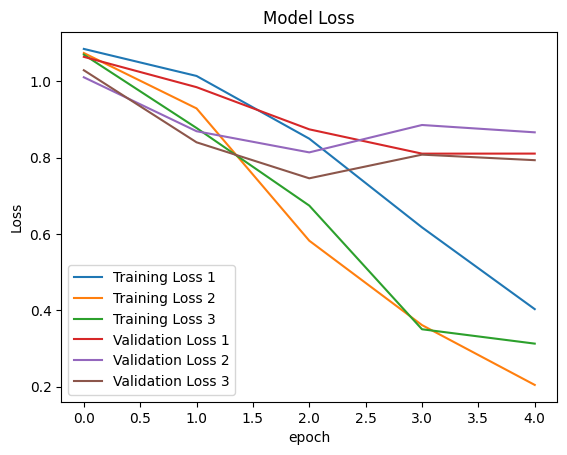

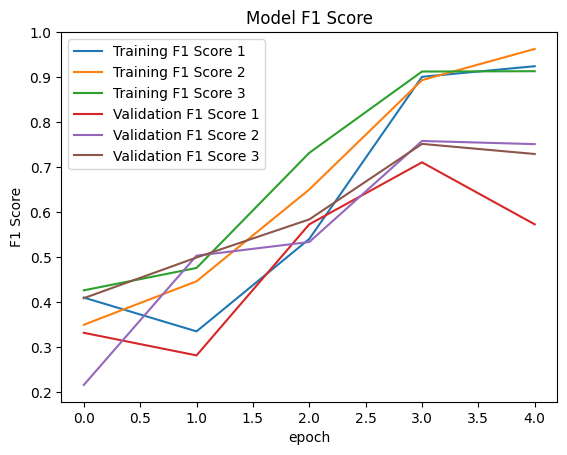

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - f1_score: 0.6023 - loss: 0.7757
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - f1_score: 0.7288 - loss: 0.8862
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 686ms/step - f1_score: 0.6936 - loss: 0.9140
Test accuracy 1: 0.5998
Test accuracy 2: 0.7208
Test accuracy 3: 0.6928


In [122]:
history_1 = n_cell_1_model.fit(X_train, y_train_cat, validation_data = (X_val, y_val_cat), epochs=5, batch_size=32)
history_2 = n_cell_2_model.fit(X_train, y_train_cat, validation_data = (X_val, y_val_cat), epochs=5, batch_size=32)
history_3 = n_cell_3_model.fit(X_train, y_train_cat, validation_data = (X_val, y_val_cat), epochs=5, batch_size=32)

plt.plot(history_1.history['loss'], label="Training Loss 1")
plt.plot(history_2.history['loss'], label="Training Loss 2")
plt.plot(history_3.history['loss'], label="Training Loss 3")
plt.plot(history_1.history['val_loss'], label="Validation Loss 1")
plt.plot(history_2.history['val_loss'], label="Validation Loss 2")
plt.plot(history_3.history['val_loss'], label="Validation Loss 3")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

plt.plot(history_1.history['f1_score'], label="Training F1 Score 1")
plt.plot(history_2.history['f1_score'], label="Training F1 Score 2")
plt.plot(history_3.history['f1_score'], label="Training F1 Score 3")
plt.plot(history_1.history['val_f1_score'], label="Validation F1 Score 1")
plt.plot(history_2.history['val_f1_score'], label="Validation F1 Score 2")
plt.plot(history_3.history['val_f1_score'], label="Validation F1 Score 3")
plt.title('Model F1 Score')
plt.ylabel('F1 Score')
plt.xlabel('epoch')
plt.legend()
plt.show()

test_loss_1, test_acc_1 = n_cell_1_model.evaluate(X_test, y_test_cat)
test_loss_2, test_acc_2 = n_cell_2_model.evaluate(X_test, y_test_cat)
test_loss_3, test_acc_3 = n_cell_3_model.evaluate(X_test, y_test_cat)
print(f"Test accuracy 1: {test_acc_1:.4f}")
print(f"Test accuracy 2: {test_acc_2:.4f}")
print(f"Test accuracy 3: {test_acc_3:.4f}")

Peningkatan ukuran layer (cell size) cenderung meningkatkan performa model, tetapi peningkatan yang terlalu banyak dapat menyebabkan overfitting.

## 4.3. Variasi Arah

### 4.1.1. Modeling

#### 4.1.1.1 Model 1

In [123]:
unidirectional_model = Sequential([
    vectorize_layer,
    Embedding(input_dim=max_tokens, output_dim=64, mask_zero=True,embeddings_initializer=keras.initializers.RandomUniform(seed=42)),
    LSTM(64, return_sequences=True, kernel_initializer=keras.initializers.GlorotNormal(seed=42)),
    LSTM(32, return_sequences=True, kernel_initializer=keras.initializers.GlorotNormal(seed=42)),
    LSTM(16, kernel_initializer=keras.initializers.GlorotNormal(seed=42)),
    Dropout(0.5, seed=42),
    Dense(3, activation='softmax', kernel_initializer=keras.initializers.GlorotNormal(seed=42))
])

unidirectional_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=[f1]
)

#### 4.1.1.2 Model 2

In [124]:
bidirectional_model = Sequential([
    vectorize_layer,
    Embedding(input_dim=max_tokens, output_dim=64, mask_zero=True,embeddings_initializer=keras.initializers.RandomUniform(seed=42)),
    Bidirectional(LSTM(64, return_sequences=True, kernel_initializer=keras.initializers.GlorotNormal(seed=42))),
    Bidirectional(LSTM(32, return_sequences=True, kernel_initializer=keras.initializers.GlorotNormal(seed=42))),
    Bidirectional(LSTM(16, kernel_initializer=keras.initializers.GlorotNormal(seed=42))),
    Dropout(0.5, seed=42),
    Dense(3, activation='softmax', kernel_initializer=keras.initializers.GlorotNormal(seed=42))
])

bidirectional_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=[f1]
)

### 4.1.2. Comparison and Analysis

Epoch 1/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 205ms/step - f1_score: 0.5493 - loss: 1.0875 - val_f1_score: 0.2370 - val_loss: 1.0287
Epoch 2/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - f1_score: 0.3368 - loss: 0.9852 - val_f1_score: 0.4425 - val_loss: 0.9818
Epoch 3/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - f1_score: 0.5123 - loss: 0.9127 - val_f1_score: 0.6640 - val_loss: 0.9015
Epoch 4/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 259ms/step - f1_score: 0.7486 - loss: 0.7591 - val_f1_score: 0.5309 - val_loss: 0.8813
Epoch 5/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 237ms/step - f1_score: 0.9028 - loss: 0.4751 - val_f1_score: 0.6044 - val_loss: 0.9432
Epoch 1/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 33s 606ms/step - f1_score: 0.4475 - loss: 1.0733 - val_f1_score: 0.2000 - val_loss: 1.0279
Epoch 2/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 628ms/step - f1_score: 0.3632 - loss: 0.9527 - val_f1_score: 0.4694 - val_loss: 0.8835
Epoch 3/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 518ms/step - f1_score: 0.7123 - loss: 0.6540 - val_f1_score: 0.5486 

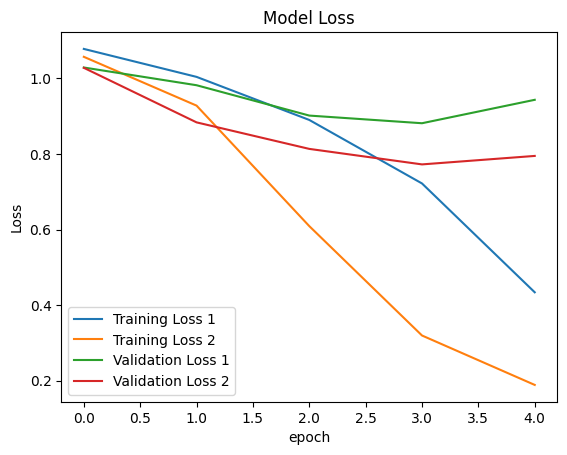

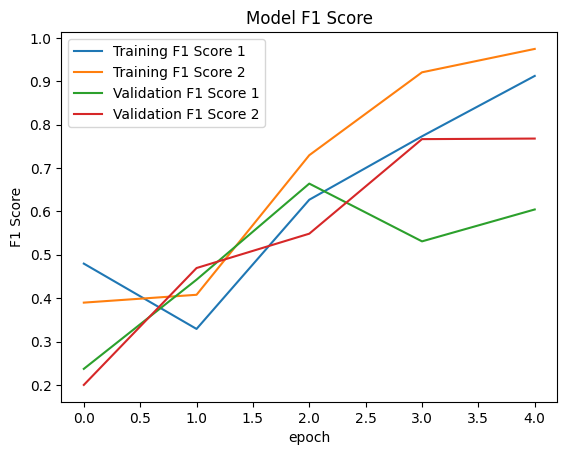

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - f1_score: 0.6563 - loss: 0.8702
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - f1_score: 0.7331 - loss: 0.8378
Test accuracy 1: 0.6730
Test accuracy 2: 0.7201


In [125]:
history_1 = unidirectional_model.fit(X_train, y_train_cat, validation_data = (X_val, y_val_cat), epochs=5, batch_size=32)
history_2 = bidirectional_model.fit(X_train, y_train_cat, validation_data = (X_val, y_val_cat), epochs=5, batch_size=32)

plt.plot(history_1.history['loss'], label="Training Loss 1")
plt.plot(history_2.history['loss'], label="Training Loss 2")
plt.plot(history_1.history['val_loss'], label="Validation Loss 1")
plt.plot(history_2.history['val_loss'], label="Validation Loss 2")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

plt.plot(history_1.history['f1_score'], label="Training F1 Score 1")
plt.plot(history_2.history['f1_score'], label="Training F1 Score 2")
plt.plot(history_1.history['val_f1_score'], label="Validation F1 Score 1")
plt.plot(history_2.history['val_f1_score'], label="Validation F1 Score 2")
plt.title('Model F1 Score')
plt.ylabel('F1 Score')
plt.xlabel('epoch')
plt.legend()
plt.show()

test_loss_1, test_acc_1 = unidirectional_model.evaluate(X_test, y_test_cat)
test_loss_2, test_acc_2 = bidirectional_model.evaluate(X_test, y_test_cat)
print(f"Test accuracy 1: {test_acc_1:.4f}")
print(f"Test accuracy 2: {test_acc_2:.4f}")



Tidak terdapat perbedaan performa yang terlalu signifikan antara bidirectional dan unidirectional layer. Namun, bidirectional layer cenderung memberi hasil yang lebih baik daripada unidirectional layer. Hal ini mungkin dikarenakan persoalan pemrosesan kalimat, seperti penentuan sentimen, cenderung membutuhkan konteks dari kedua sisi kalimat.

# 5. Model from Scratch

## 5.1. Modeling

In [ ]:
# ...

## 5.2. Comparison & Analysis

In [ ]:
# ...

`Provide your analysis here`